**Multilabel classifier**

In [ ]:
# Load dataset

from google.colab import drive
import pandas as pd

drive.mount("/content/drive")

# Experimental Data for Question Classification (Cognitive Computation Group, University of Pennsylvania)
# https://cogcomp.seas.upenn.edu/Data/QA/QC/
train_data = open('/content/drive/My Drive/data/questions/training_data.txt', 'r+')
test_data = open('/content/drive/My Drive/data/questions/test_dataset.txt', 'r+')

Mounted at /content/drive


In [ ]:
# Define train and test dataset

train = pd.DataFrame(train_data.readlines(), columns = ['Question'])
test = pd.DataFrame(test_data.readlines(), columns = ['Question'])

train['QType'] = train.Question.apply(lambda x: x.split(' ', 1)[0])
train['Question'] = train.Question.apply(lambda x: x.split(' ', 1)[1])
train['QType-Coarse'] = train.QType.apply(lambda x: x.split(':')[0])
train['QType-Fine'] = train.QType.apply(lambda x: x.split(':')[1])
test['QType'] = test.Question.apply(lambda x: x.split(' ', 1)[0])
test['Question'] = test.Question.apply(lambda x: x.split(' ', 1)[1])
test['QType-Coarse'] = test.QType.apply(lambda x: x.split(':')[0])
test['QType-Fine'] = test.QType.apply(lambda x: x.split(':')[1])

train.pop('QType')
train.pop('QType-Fine')
test.pop('QType')
test.pop('QType-Fine')

train_dataset = train.Question.tolist()
test_dataset = test.Question.tolist()

print("Number of (raw) train documents:", len(train_dataset))
print("Number of (raw) test documents:", len(test_dataset))

Number of (raw) train documents: 5452
Number of (raw) test documents: 500


In [ ]:
# Define labels

import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

y_names = np.unique(np.array(train['QType-Coarse']))

le = LabelEncoder()
le.fit(pd.Series(train['QType-Coarse'].tolist() + test['QType-Coarse'].tolist()).values)
train['QType-Coarse'] = le.transform(train['QType-Coarse'].values)
test['QType-Coarse'] = le.transform(test['QType-Coarse'].values)

y_train = np_utils.to_categorical(train['QType-Coarse'], train['QType-Coarse'].nunique())
y_test = np_utils.to_categorical(test['QType-Coarse'], train['QType-Coarse'].nunique())

print("Labels:", y_names)

Labels: ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']


In [ ]:
# Text preprocessing

import nltk
from nltk.tokenize import regexp_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

def preprocess(raw_dataset):
  dataset = []
  stemmer = SnowballStemmer("english")
  stopwords_en = stopwords.words("english")

  for i in range(0, len(raw_dataset)):
    tokens = regexp_tokenize(str(raw_dataset[i]), r"\w+")
    stems = [stemmer.stem(token) for token in tokens]
    words_no_stopwords = [word for word in stems if word not in stopwords_en]
    document = ' '.join(words_no_stopwords)
    dataset.append(document)
  
  return dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Feature extraction (converting text to vectors)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

preprocessed_train_dataset = preprocess(train_dataset)
X_train = vectorizer.fit_transform(preprocessed_train_dataset).toarray()

preprocessed_test_dataset = preprocess(test_dataset)
X_test = vectorizer.transform(preprocessed_test_dataset).toarray()

In [ ]:
# Exploratory analysis

vocabulary_size = X_train.shape[1]
number_of_classes = len(y_names)

print("Number of (preprocessed) train documents:", len(preprocessed_train_dataset))
print("Number of (preprocessed) test documents:", len(preprocessed_test_dataset))
print("Vocabulary size:", vocabulary_size)
print("Number of classes:", number_of_classes)
print("Vectorized train dataset (number of documents, vocabulary size):", X_train.shape)
print("Vectorized test dataset (number of documents, vocabulary size):", X_test.shape)

Number of (preprocessed) train documents: 5452
Number of (preprocessed) test documents: 500
Vocabulary size: 6783
Number of classes: 6
Vectorized train dataset (number of documents, vocabulary size): (5452, 6783)
Vectorized test dataset (number of documents, vocabulary size): (500, 6783)


In [ ]:
# Create model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Dense(128, activation="relu", input_dim=vocabulary_size))
model.add(Dropout(0.3))
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               868352    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 869,126
Trainable params: 869,126
Non-trainable params: 0
_________________________________________________________________


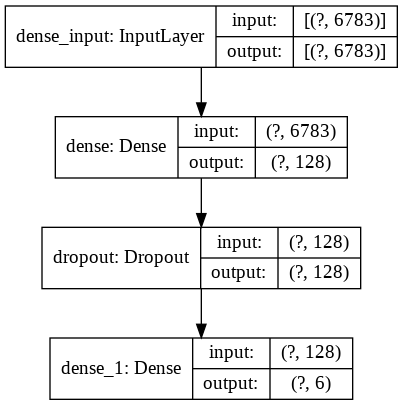

In [ ]:
# Plot model

from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Fit model

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100)

Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 1.7265 - accuracy: 0.3454 - val_loss: 1.6487 - val_accuracy: 0.5160
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 1.4601 - accuracy: 0.6695 - val_loss: 1.4021 - val_accuracy: 0.6800
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 1.0758 - accuracy: 0.8146 - val_loss: 1.1508 - val_accuracy: 0.7200
Epoch 4/10
55/55 [==============================] - 1s 14ms/step - loss: 0.7369 - accuracy: 0.8679 - val_loss: 1.0018 - val_accuracy: 0.7380
Epoch 5/10
55/55 [==============================] - 1s 14ms/step - loss: 0.5146 - accuracy: 0.9024 - val_loss: 0.9189 - val_accuracy: 0.7380
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.3744 - accuracy: 0.9307 - val_loss: 0.8853 - val_accuracy: 0.7360
Epoch 7/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2832 - accuracy: 0.9479 - val_loss: 0.8613 - val_accuracy: 0.7340
Epoch 8/10
55

In [ ]:
# Evaluate model

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9892
Testing Accuracy:  0.7300


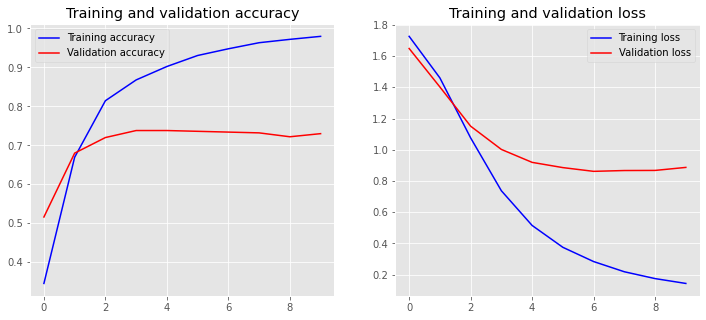

In [ ]:
# Plot loss and accuracy for the training and testing data 

import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(0, len(acc))
  
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training accuracy')
  plt.plot(x, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

plot_history(history)

In [ ]:
# Predict unseen data
unseen_sentence = input("Enter a question: ")
X_unseen = vectorizer.transform([unseen_sentence]).toarray()
y_unseen = np.argmax(model.predict(X_unseen), axis=-1) # Equivalent to: y_unseen = model.predict_classes(X_unseen)

print("Possible classes:", y_names)
print("The pedicted class for that question is:", y_unseen)
for i in y_unseen:
  print("\t", y_names[i])

Enter a question: The students are working hard
Possible classes: ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']
The pedicted class for that question is: [3]
	 HUM


In [ ]:
# Savel model

import h5py

model_structure = model.to_json()

with open("multilabel_classifier_model.json", "w") as json_file:
  json_file.write(model_structure)

model.save_weights("multilabel_classifier_weights.h5")

In [ ]:
# Load model

from keras.models import model_from_json

with open("multilabel_classifier_model.json", "r") as json_file:
  loaded_model = model_from_json(json_file.read())

loaded_model.load_weights("multilabel_classifier_weights.h5")

loaded_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

loss, accuracy = loaded_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9892
Testing Accuracy:  0.7300
